# Multilayer Perceptrons (MLPs) for Character-Level Language Modeling

This notebook builds on the concepts of backpropagation introduced in the previous lesson and explores how we can use MLPs to tackle character-level language modeling, inspired by Yoshua Bengio's 'Neural Probabilistic Language Model' paper.


## 1. From Backpropagation to Neural Networks

In the previous lesson, we explored how backpropagation allows us to efficiently compute gradients in computational graphs. Now we'll see how this enables training of more complex neural networks.

Let's start by importing our required libraries:


In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Character-Level Language Modeling

We'll build a character-level language model for name generation, similar to the makemore example from Andrej Karpathy's nn-zero-to-hero series.

First, let's load our dataset of names:


In [5]:
# Load the names dataset
with open('../../training_data/names.txt', 'r') as f:
    names = f.read().splitlines()

print(f"Total number of names: {len(names)}")
print(f"First 10 examples: {names[:10]}")

Total number of names: 32033
First 10 examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


### 2.1 Building the Character Vocabulary

For character-level language modeling, we first need to identify all unique characters in our dataset and create mappings between characters and indices:


In [6]:
# Build the vocabulary of characters
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}  # mapping from char to index
stoi['.'] = 0                               # special '.' token representing "start/end of name"
itos = {i:s for s,i in stoi.items()}        # mapping from index to char

print(f"Vocabulary size: {len(stoi)}")
print(f"Character mapping: {stoi}")

Vocabulary size: 27
Character mapping: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


### 2.2 Generating Training Examples

Our task is to predict the next character given a context of previous characters. We'll create a dataset from our names:


In [7]:
# Create a dataset of context-target pairs
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # Add the special '.' token at beginning and end
        context = [0] * block_size  # initialize with block_size '.' tokens
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # Slide the context window by one character
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

# Split the data into train/validation/test sets
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

X_train, Y_train = build_dataset(names[:n1])
X_val, Y_val = build_dataset(names[n1:n2])
X_test, Y_test = build_dataset(names[n2:])

print(f"Training examples: {X_train.shape[0]}")
print(f"Validation examples: {X_val.shape[0]}")
print(f"Test examples: {X_test.shape[0]}")

Training examples: 182625
Validation examples: 22655
Test examples: 22866


Let's look at some training examples to understand the data:


In [8]:
# Show a few examples of context -> target in the training set
print("Context -> Target examples:")
for i in range(5):
    context = ''.join(itos[j] for j in X_train[i].tolist())
    target = itos[Y_train[i].item()]
    print(f"'{context}' -> '{target}'")

Context -> Target examples:
'...' -> 'y'
'..y' -> 'u'
'.yu' -> 'h'
'yuh' -> 'e'
'uhe' -> 'n'


## 3. Understanding the MLP Architecture for Language Modeling

Let's build a model inspired by Karpathy's makemore example. We'll break down the architecture into components:

1. **Embedding Layer**: Convert character indices to learned vectors
2. **MLP Hidden Layer**: Process the flattened embeddings
3. **Output Layer**: Produce logits for next character prediction


In [9]:
# Let's see how our data shapes would flow through the network
# Initialize random parameters
vocab_size = len(stoi)  # size of character vocabulary
embedding_dim = 10      # size of embedding vectors

# Random character embeddings
C = torch.randn((vocab_size, embedding_dim))
print(f"Character embedding matrix shape: {C.shape}")

# Look at a sample batch of inputs
sample_batch = X_train[:32]  # take 32 examples
print(f"Input batch shape: {sample_batch.shape}")

# Get embeddings for each character in the context
emb = C[sample_batch]  # look up embeddings for each character
print(f"Embeddings shape: {emb.shape}")

# Reshape to prepare for the MLP
emb_flat = emb.reshape(emb.shape[0], -1)  # flatten the context embeddings
print(f"Flattened embeddings shape: {emb_flat.shape}")

Character embedding matrix shape: torch.Size([27, 10])
Input batch shape: torch.Size([32, 3])
Embeddings shape: torch.Size([32, 3, 10])
Flattened embeddings shape: torch.Size([32, 30])


In [10]:
# Now let's define our full model
class NameGenerationMLP(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
        super().__init__()
        # Embedding layer
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        
        # Calculate input dimension for hidden layer
        input_dim = context_size * embedding_dim
        
        # Hidden layer
        self.hidden = torch.nn.Linear(input_dim, hidden_dim)
        
        # Output layer
        self.output = torch.nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        # x shape: (batch_size, context_size)
        
        # Get embeddings
        emb = self.embeddings(x)  # (batch_size, context_size, embedding_dim)
        
        # Flatten embeddings
        emb_flat = emb.view(emb.shape[0], -1)  # (batch_size, context_size * embedding_dim)
        
        # Apply hidden layer with tanh activation
        h = torch.tanh(self.hidden(emb_flat))  # (batch_size, hidden_dim)
        
        # Apply output layer to get logits
        logits = self.output(h)  # (batch_size, vocab_size)
        
        return logits

Let's initialize our model with reasonable hyperparameters:


In [11]:
# Model hyperparameters
embedding_dim = 10     # Dimension of character embeddings
context_size = block_size  # Number of context characters
hidden_dim = 200       # Size of hidden layer

# Create the model
model = NameGenerationMLP(vocab_size, embedding_dim, context_size, hidden_dim)

# Display model architecture
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

NameGenerationMLP(
  (embeddings): Embedding(27, 10)
  (hidden): Linear(in_features=30, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=27, bias=True)
)
Total number of parameters: 11897


## 4. Training the Model

Now let's train our model using minibatch gradient descent:


Epoch 1/10, Train Loss: 2.3808, Val Loss: 2.5395
Epoch 2/10, Train Loss: 2.2786, Val Loss: 2.4266
Epoch 3/10, Train Loss: 2.2418, Val Loss: 2.5274
Epoch 4/10, Train Loss: 2.2194, Val Loss: 2.4611
Epoch 5/10, Train Loss: 2.2040, Val Loss: 2.2141
Epoch 6/10, Train Loss: 2.1920, Val Loss: 2.5344
Epoch 7/10, Train Loss: 2.1840, Val Loss: 2.5597
Epoch 8/10, Train Loss: 2.1770, Val Loss: 2.4171
Epoch 9/10, Train Loss: 2.1711, Val Loss: 2.3381
Epoch 10/10, Train Loss: 2.1678, Val Loss: 2.3447


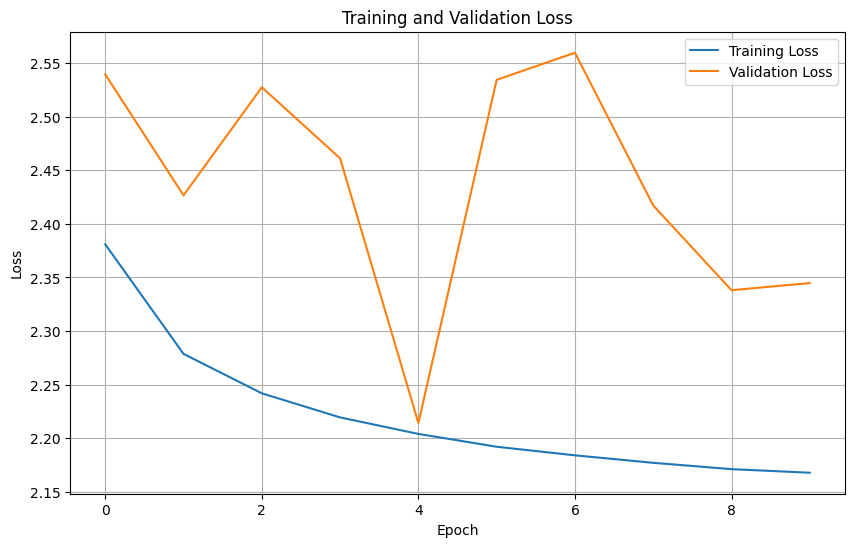

In [12]:
# Training configuration
batch_size = 32
learning_rate = 0.1
num_epochs = 10

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    batch_count = 0
    
    # Create random permutation of training examples
    indices = torch.randperm(X_train.shape[0])
    
    # Train in batches
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch
        idx = indices[i:i+batch_size]
        inputs = X_train[idx]
        targets = Y_train[idx]
        
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track statistics
        total_loss += loss.item()
        batch_count += 1
    
    # Calculate average loss for this epoch
    avg_train_loss = total_loss / batch_count
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = criterion(val_logits, Y_val).item()
        val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Evaluating the Model

Let's evaluate our model on the test set and examine its performance:


In [13]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    # Compute loss
    test_logits = model(X_test)
    test_loss = criterion(test_logits, Y_test)
    
    # Compute accuracy
    _, predicted = torch.max(test_logits, 1)
    correct = (predicted == Y_test).sum().item()
    total = Y_test.size(0)
    accuracy = correct / total
    
print(f"Test Loss: {test_loss.item():.4f}")
print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")

Test Loss: 2.3457
Accuracy: 0.3112 (7116/22866)


## 6. Generating New Names

Now for the fun part - let's use our trained model to generate new names! We'll sample one character at a time following the model's predictions:


In [14]:
def generate_name(model, max_length=20):
    """
    Generate a new name using the trained model.
    """
    # Start with all '.' tokens (beginning of name)
    context = [0] * block_size
    name = []
    
    # Generate one character at a time
    model.eval()
    with torch.no_grad():
        while True:
            # Get model predictions
            x = torch.tensor([context])
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            
            # Sample a character from the distribution
            idx = torch.multinomial(probs, num_samples=1).item()
            
            # If we get '.' or reach max length, we're done
            if idx == 0 or len(name) >= max_length:
                break
                
            # Add the character to our name
            name.append(itos[idx])
            
            # Update the context by sliding the window
            context = context[1:] + [idx]
    
    return ''.join(name)

# Generate 20 names
print("Generated Names:")
print("---------------")
for _ in range(20):
    print(generate_name(model))

Generated Names:
---------------
motan
romi
ada
madeyah
mhie
mazie
emey
mis
may
mih
mayan
moni
maahrissa
maki
mandalynn
miria
brah
neid
mavukt
man


## 7. Understanding the Model's Predictions

Let's examine what the model has learned by looking at its predictions for different character contexts:


In [15]:
def analyze_context(model, context_str):
    """
    Analyze the model's predictions for a given context string.
    """
    # Ensure context is the right length
    if len(context_str) < block_size:
        context_str = '.' * (block_size - len(context_str)) + context_str
    elif len(context_str) > block_size:
        context_str = context_str[-block_size:]
    
    # Convert to indices
    context = [stoi.get(c, 0) for c in context_str]  # Use 0 if character not in vocab
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0]
    
    # Display top 5 predictions
    top_probs, top_indices = torch.topk(probs, 5)
    
    print(f"Context: '{context_str}'")
    print("Top 5 predicted next characters:")
    for i in range(5):
        char = itos[top_indices[i].item()]
        prob = top_probs[i].item() * 100
        print(f"  '{char}': {prob:.2f}%")
    print()

# Test with some sample contexts
contexts = ['...', 'joh', 'mar', 'sar', 'eli', 'th']
for ctx in contexts:
    analyze_context(model, ctx)

Context: '...'
Top 5 predicted next characters:
  'm': 73.96%
  's': 3.19%
  'j': 2.38%
  'l': 2.19%
  'k': 2.17%

Context: 'joh'
Top 5 predicted next characters:
  'a': 48.19%
  'n': 21.82%
  'i': 13.36%
  'e': 7.83%
  'y': 1.53%

Context: 'mar'
Top 5 predicted next characters:
  'i': 53.36%
  'y': 8.92%
  'a': 6.16%
  'e': 5.07%
  'l': 4.84%

Context: 'sar'
Top 5 predicted next characters:
  'i': 32.52%
  'a': 19.90%
  'y': 11.11%
  'e': 5.88%
  '.': 5.09%

Context: 'eli'
Top 5 predicted next characters:
  'a': 32.62%
  'n': 15.11%
  's': 10.45%
  '.': 9.01%
  'z': 6.93%

Context: '.th'
Top 5 predicted next characters:
  'a': 56.29%
  'e': 24.81%
  'i': 7.56%
  'y': 5.41%
  'o': 3.87%



## 8. How This Relates to Modern Neural Networks

The MLP we've built here is a foundational architecture in neural language modeling, directly inspired by Bengio's original paper. Here's how it compares to more advanced models:

### Key Limitations:

1. **Fixed Context Window**: Our model can only see a fixed number of previous characters.
2. **No Parameter Sharing**: Characters in different positions don't share weights.
3. **No Recurrence**: There's no built-in mechanism to maintain state across predictions.

### How Modern Architectures Improve on This:

1. **RNNs/LSTMs**: Add recurrent connections to maintain state across time steps.
2. **Transformers**: Use attention mechanisms to weigh the importance of different context elements.
3. **Positional Encodings**: Add position information to help the model understand sequence order.

Despite these limitations, our model demonstrates the core ideas of neural language modeling and shows how even a simple MLP can learn useful patterns for text generation.


## Conclusion

In this notebook, we've explored how MLPs can be applied to character-level language modeling for name generation. We've seen:

1. How to prepare character-level data for language modeling
2. How to design and implement an MLP architecture for next-character prediction
3. How to train the model and generate new names
4. How to analyze and visualize what the model has learned

This approach represents a key stepping stone from traditional n-gram models toward modern neural language models. By learning continuous representations for characters and modeling their relationships, our model can capture complex patterns in the data and generate reasonably realistic names.
